<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Ana Sofia Dürrmüller Acosta y Jose Alberto Mayagoitia Gutierrez

**Fecha:** 25 de Noviembre 

**Expediente** : if723489 y if720266

**Profesor:** Oscar David Jaramillo Zuluaga.

**Link Github:** https://github.com/anadurrmuller/Tarea10_ASDurrmuller_JAMayagoitia.git

# Tarea 10

Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:

1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea down-and-out o Up-and-out defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

In [ ]:
# Resultados de Ana Sofia

In [ ]:
# Resultados de Jose Alberto

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp # Histograma de rendimientos  sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
%matplotlib inline

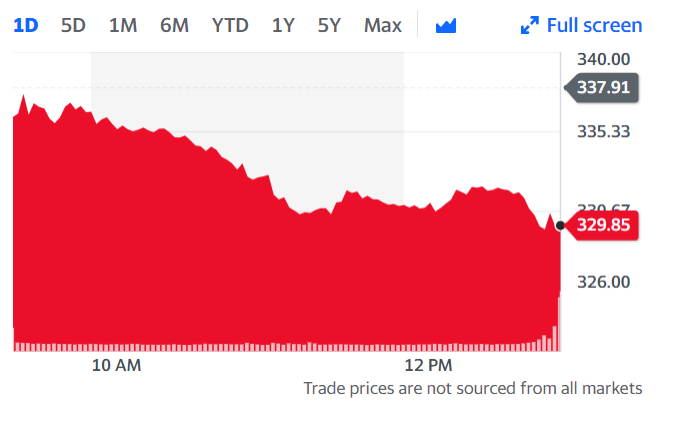

In [ ]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [ ]:
closes = get_adj_closes(['MSFT'], '2017-01-01')
closes_MSFT = closes.loc[:,'MSFT']
closes_MSFT

In [ ]:
closes_MSFT.plot(figsize=(8,6));

In [ ]:
closes_MSFT[-1]

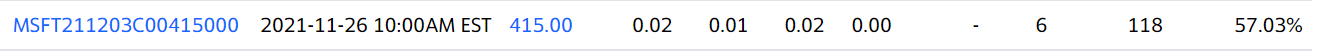

### Histograma de Rendimientos

In [ ]:
ret_MSFT = calc_daily_ret(closes_MSFT)
closes_MSFT,closes_MSFT[-1]

In [ ]:
mu = ret_MSFT.mean()
sigma = ret_MSFT.std()
r = 0.0021/360 
mu, sigma, r

In [ ]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_MSFT-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)

In [ ]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022-01-21'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 415
S0 = closes_MSFT.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:]=S0

In [ ]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [ ]:
call_hist.iloc[-1]

### Call down-and-out

#### Strike de 415

In [ ]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 415
S0 = closes_MSFT.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
sim_closes.iloc[0,:] = S0

In [ ]:
sim_closes

In [ ]:
pd.set_option('display.max_columns', 15)

# Precio barrera
B = 300

# Función de activación (knock-in)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes > B).cumprod(axis=0)  > 0
I

In [ ]:
closes_MSFT.plot()

In [ ]:
K = 415
S0 = S0
K, S0

In [ ]:
# Definir barrera
B = 327
# Crear función indicadora
I = (sim_closes > B).cumprod(axis=0)  > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

In [ ]:
call.iloc[-1]

Al graficar nuestras primas observamos en comparacion que si nos da una prima menor, en la grafica vemos la tendencia alcista lo cual nos dice que si llega a tocar nuestro precio barrera de 315 la opcion se anula.

### Put Up-and-out

#### Strike 290

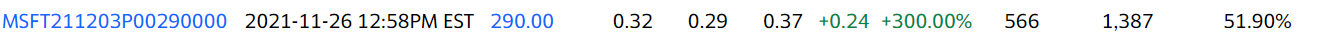

In [ ]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = '2022-01-21'

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = 290
S0 = closes_MSFT.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())
sim_closes_hist.iloc[0,:]=S0

In [ ]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [ ]:
call_hist.iloc[-1]

In [ ]:
pd.set_option('display.max_columns', 15)

# Precio barrera
B = 350

# Función  (Put  up and out )
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes < B).cumprod(axis=0)  > 0
I

In [ ]:
K = 290
S0 = S0
K, S0

In [ ]:
# Definir barrera
B = 340
# Crear función indicadora
I = (sim_closes < B).cumprod(axis=0)  > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike-sim_closes, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima up and out ':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax)

In [ ]:
callui.iloc[-1]

Al analizar la grafica observamos que tuvimos una prima menor a la europea, la cual tiene tendencia alcista.